---
---
---
## Imports

In [1]:
# Data handling and visualization
from joblib import dump
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Data preparation
from sklearn.model_selection import train_test_split

# Pipeline building
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipe
from sklearn.compose import ColumnTransformer

# Cross-validation and evaluation metrics
from scipy.stats import uniform, randint, loguniform
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, average_precision_score, precision_recall_curve, auc, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Classifier algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Under & over-sampling algorithms
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

# TensorFlow imports for NN
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.metrics import Recall, Precision, RecallAtPrecision, PrecisionAtRecall, F1Score
from keras import optimizers
from scikeras.wrappers import KerasClassifier

2025-02-17 06:37:02.984268: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


---
---
## **This notebook contains the following**:
1. Evaluation Metrics Discussion
2. Baseline Testing
3. Sampling Trials and Evaluations
4. Hyperparameter Tuning of Models
5. Decision Threshold Tuning


---
---
## **1. Evaluation Metrics**

***Recall***  
Recall is the primary metric in this binary classification problem. In fraud detection it is extremely important to correctly identify as many as possible, or close to all fraudulent transactions. Therefore recall will be the key metric.

***Precision***  
Creating a model with very high recall will usually have to trade-off for some loss in precision, especially when the dataset is highly imbalanced. As a lower level of precision will likely lead to an increase in false positives, the additional costs would need to be considered for the models specific deployment and productivization case. Precision will need to considered as an important secondary metric. Some foreseen drawbacks of lower precision:
- Higher servicing costs in verifying.
- Extra inconvenience to legitimate customers.

***F1 Score***  
F1 score provides useful insight into the balance and tradeoff between recall and precision, allowing for more rapid evaluation of cross validation results.

---
### **Why PR-AUC and not ROC-AUC?**

ROC: Receiver Operating Characteristic  
PR: Precision Recall  
AUC: Area Under Curve  

Due to the enormous imblance in the classes, an ROC-AUC score is not such an appropriate metric of model performance on the test set as:
- ROC curves plot the True Positive Rate (TPR) against the False Positive Rate (FPR)
- In highly imbalanced datasets, the majority class (in this case 'Not Fraud') dominates the FPR, which can make the curve look good even if the model rarely predicts the minority class.
- If the model just predicts Not Fraud for every case, FPR is still low because the negative (Not Fraud) class is so large relative the positive (fraud) class.
- Therefore ROC-AUC can still be high even if the model is failing to detect the minority class.
- ROC-AUC doesnt directly measure how well the model separates the minority class, and both classes get treated equally.
- So a model with high ROC-AUC can still have poor recall for minority class, which is a critically important performance metric in fraud detection!

PR-AUC is a much more appropriate metric:
- It focusses on the positive (in this case minority) class.
- It consider the precision (TP/(TP+FP)) and recall (TP/(TP+FN)), which is very important when developing a real world application for a classification model.
- Not using the majority class in the denominator means that simply not predicting the minority class will give a low PR-AUC score and therefore better reflect the models overall performance. 

I will include both metrics in my evaluations to try to exemplify these ideas but will pay closer attention to PR-AUC score.

---
---
## **Data Preparation**
#### 1. Load Data

In [20]:
data = pd.read_csv('../data/creditcard.csv')
data = data.drop_duplicates()
# data['Class'] = data['Class'].astype('bool')

#### 2. Train, Test Split

In [7]:
target = 'Class'

X_train, X_test, y_train, y_test = train_test_split(data.drop(target,axis=1), data[target], test_size=0.3, stratify=data[target], random_state=42)

#### 3. Define Target & X, y Pairs

---
---
## **Baseline Testing**

This projects is an investigation of some of SKLearn's built in oversampling and undersampling algorithms. Before these can be tested and evaluated, baseline metrics need to be generated through cross validation with the training set. I also want to investigate how some of the  classifier algorithms perform in an imbalanced dataset scenario to help improve my understanding of how they work and intuition about which algorithms are likely to work in a given case.

I am going to trial the following algorithms:
- Logistic Regression
- Random Forest Classifier
- XGBoost Classifier
- Multi-Layer Perceptron (MLP Neural Network)

---
## **Notes on MLP Loss Functions**
The MLP Classifier needs to be created using a function and then wrapped in a `KerasClassfier` object. This allows for integration of the Keras Sequential model with imblearn pipelines and for hyperparamter tuning with sklearn's RandomizedSearchCV.

**Loss Functions**:  

**BCE**:

The typical loss function for binary classification problems is binary crossentropy, which is defined as:  

$\text{BCE} = -\frac{1}{N} \sum_{i=1}^{N} \left[y_i \log(\hat{y_i}) + (1 - y_i) \log(1 - \hat{y_i}) \right]$

Where:
- $ y_i $ is the true label ($ 0 $ or $ 1 $).
- $ \hat{y_i} $ is the predicted probability for class $ 1 $.
- $ N $ is the total number of samples.

However, while BCE generally performs well on balanced datasets, there are some drawbacks that i have assumed will negatively impact performance and intreptability of results when applied to an imbalanced dataset:
1. Strong influence of majority class:
    - BCE has a tendency to favor the majority class, which can lead to high accuracy scores, however poor recall for the minority class, which is the opposite of what i want to achieve with this model.
2. Misclassification of minority class:
    - As the majority class dominates the loss, errors in predicting minority class instances contribute insignificantly to gradient updates

**Focal Loss**:

I am going to use Focal Loss ('binary_focal_crossentropy'), an extension of BCE, designed to down-weight well-classified instances and focus more on misclassifications. It introduces a tunable focusing parameter $\gamma$, which adjusts the contribution of easy vs hard instances to classify.

Focal loss is defined as:

$\text{FL}(p_t) = -\alpha (1 - p_t)^\gamma \log(p_t)$

Where:
- $ p_t $ is the predicted probability for the correct class:
  $p_t =\begin{cases} \hat{y} & \text{if } y = 1 \\1 - \hat{y} & \text{if } y = 0\end{cases}$

- $ \gamma $ (gamma) is the focusing parameter, controlling the down-weighting of well-classified examples.
- $ \alpha $ is a weighting factor for handling class imbalance.

- When $ \gamma = 0 $, Focal Loss reduces to Binary Cross-Entropy.
- As $ \gamma $ increases, the loss reduces for easy samples and focuses more on misclassified cases.

**Perceived Advantage Over BCE**:

1. Improved performance on minority class:
    - Hard to classify instances contribute more to the loss, forcing the model to better learn from them
2. Reduce dominance of easy examples:
    - Well- classified samples have a very low impact on the updating process of weights as the model learns, allowing it to focus more on difficult cases.
3. Reduce false negatives:
    - The end goal is to reduce the number of misclassified minority class instances as this is critical in Fraud detection.

**Extension Investigations**:

1. Trial both loss functions and compare model performance
2. Trial higher $\gamma$ values in focal loss to further down-weight easy examples and focus even more on misclassified minority cases.
Comparison: 


In [ ]:
# Instantiate sklearn algorithms
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(random_state=13)
xgb = XGBClassifier(objective='binary:logistic', random_state=13)

# Create MLP model building function
def create_model(neurons=64, learning_rate=0.001, dropout_rate=0.2, optimizer=optimizers.Adam, loss='binary_focal_crossentropy', metrics=[PrecisionAtRecall(recall=0.8, num_thresholds=200)]):

    # Define Keras model Input and layer params
    model = keras.Sequential([
        keras.layers.Input(shape=(X_train.shape[1] -2,)),
        keras.layers.Dense(neurons, activation='relu'),
        keras.layers.Dense(neurons, activation='relu'),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(neurons // 2, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile model
    model.compile(
        optimizer=optimizer(learning_rate=learning_rate),
        loss=loss,
        metrics=metrics
    )
    
    # Return the model
    return model

# Define Early Stopping object
es = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
)

# Instatiate mlp classifier
mlp_clf = KerasClassifier(model=create_model,
                          epochs=100,
                          batch_size=32,
                          validation_split=0.2,
                          callbacks=[es])

In [91]:
# Make an algorithms dictionary
algorithms = {
    'Logistic Regression': lr,
    'Random Forest': rf,
    'XGBoost': xgb,
    'Multi Layer Perceptron': mlp_clf
    }

# Make a dictionary of scorers compatible with cross_validate
scorers = {
    "Recall": make_scorer(recall_score, average="binary"),
    "Precision": make_scorer(precision_score, average="binary"),
    "F1 Score": make_scorer(f1_score, average="binary"),
    "PR-AUC": make_scorer(average_precision_score, response_method='predict'),
    "ROC-AUC": make_scorer(roc_auc_score, response_method='predict')
}

# Define a basic preprocessor
preprocessor_v1 = ColumnTransformer(transformers=[('drop_cols', 'drop', ['Time', 'Amount'])], remainder='passthrough', force_int_remainder_cols=False)

In [92]:
def cross_validate_models(X, y, algorithms={}, pipe_steps=[], preprocessor='v1', cv=5, scorers=None, return_cm=False):
    """
    Performs cross-validation on multiple models, generates confusion matrices, and returns evaluation metrics.
    
    Parameters:
        X, y: Features and target labels.
        algorithms: Dictionary of models, e.g., {'Logistic Regression': model1, 'Random Forest': model2}.
        pipe_steps: Steps for preprocessing pipeline.
        preprocessor: Preprocessing strategy ('v1' uses a default ColumnTransformer).
        cv: Number of cross-validation folds.
        scorers: Dictionary of scoring metrics.
        return_conf_matrices: If True, returns confusion matrices instead of classification reports.

    Returns:
        results_df: DataFrame with confusion matrix values and evaluation metrics.
        conf_matrices: Dictionary containing confusion matrices for each model.
    """
    
    # Use StratifiedKFold for better class balance in folds
    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # Set default scorers
    if scorers is None:
        scorers = {'Recall': make_scorer(recall_score, average="binary")}
    else:
        scorers = scorers

    results = {
        'Model': [],
        'Fit Time': []}

    conf_matrices = {}

    for name, alg in algorithms.items():
        # Select the correct preprocessor
        if preprocessor == 'v1':
            preprocessor = ColumnTransformer([
                ('drop_cols', 'drop', ['Time', 'Amount'])],
                remainder='passthrough')
        else:
            preprocessor = preprocessor

        # Adjust and complete pipelines
        steps = pipe_steps.copy()
        if preprocessor is not None:
            steps.insert(0, ('preprocessor', preprocessor))
        steps.append(('classifier', alg))

        # Create pipeline
        pipe = imbPipe(steps=steps)

        # Cross validate using StratifiedKFold
        print(f'Cross validating {name}...')
        cv_scores = cross_validate(pipe, X=X, y=y, scoring=scorers, cv=cv_strategy)

        # Extract correct metric keys
        metric_keys = [f'test_{metric}' for metric in scorers.keys()]
        scorer_keys = list(scorers.keys())

        # Store results for the current model
        results['Model'].append(name)
        results['Fit Time'].append(round(np.mean(cv_scores['fit_time']), 2))

        for metric, key in zip(scorer_keys, metric_keys):
            if metric not in results:
                results[metric] = []  
            results[metric].append(round(np.mean(cv_scores[key]), 2))  

        # Generate confusion matrix if requested
        if return_cm:
            print(f'Generating confusion matrix for {name}...')
            y_pred = cross_val_predict(pipe, X, y, cv=cv_strategy)
            cm = confusion_matrix(y, y_pred)
            conf_matrices[name] = cm
        
            if return_cm and 'True Negative' not in results.keys():
                results.update({
                    'True Negative': [],
                    'False Positive': [],
                    'False Negative': [],
                    'True Positive': [],
                })

            results['True Negative'].append(cm[0, 0])
            results['False Positive'].append(cm[0, 1])
            results['False Negative'].append(cm[1, 0])
            results['True Positive'].append(cm[1, 1])

    print('--- Cross Validation Complete ---')
    results_df = pd.DataFrame(results).set_index('Model')

    return (results_df, conf_matrices) if return_cm else results_df

---
---
## Baseline Metrics

Check all three classifier algorithms with all sampling techniques

In [93]:
baseline_DF, baseline_cms = cross_validate_models(X=X_train, y=y_train, algorithms=algorithms, pipe_steps=[], preprocessor='v1', scorers=scorers, return_cm=True)

Cross validating Logistic Regression...
Generating confusion matrix for Logistic Regression...
Cross validating Random Forest...
Generating confusion matrix for Random Forest...
Cross validating XGBoost...
Generating confusion matrix for XGBoost...
Cross validating Multi Layer Perceptron...
Epoch 1/100
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0046 - precision_at_recall_5: 0.0541 - val_loss: 9.0439e-04 - val_precision_at_recall_5: 0.8596
Epoch 2/100
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0012 - precision_at_recall_5: 0.6176 - val_loss: 9.4159e-04 - val_precision_at_recall_5: 0.8596
Epoch 3/100
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 7.7541e-04 - precision_at_recall_5: 0.7610 - val_loss: 8.2097e-04 - val_precision_at_recall_5: 0.8545
Epoch 4/100
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 7.0074e-04 - precision_at_recall_5: 0.8374 - val_loss: 0.0014 - val_precision_at_recall_5: 0.8621
Epoch 5/100
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step 

In [94]:
baseline_DF.to_csv('../data/baseline_cv.csv')
baseline_DF

,Fit Time,Recall,Precision,F1 Score,PR-AUC,ROC-AUC,True Negative,False Positive,False Negative,True Positive
Model,,,,,,,,,,
Logistic Regression,0.60,0.60,0.85,0.70,0.51,0.80,198242,35,133,198
Random Forest,183.01,0.79,0.94,0.86,0.74,0.90,198259,18,69,262
XGBoost,2.07,0.78,0.94,0.85,0.74,0.89,198260,17,72,259
Multi Layer Perceptron,150.87,0.75,0.85,0.80,0.64,0.88,198232,45,71,260


## Baseline Takeaway

Given that running trials on all models is computationally expensive, top 3 models based on the previously discussed evaluation metrics will be used for the following sampling trials. The top 3 models are:
1. XGBoost
2. Random Forest
3. Logistic Regression

Despite the Gaussian Naive Bayes (GNB) model achieving the highest recall score (0.83), the precision was extremely low and likely considered far too costly to use this model in production. 

The GNB model also highlighted how ROC-AUC can be a particularly misleading metric to use with an imbalanced dataset. Although the precision was extremely low, the ROC-AUC score was still extremely high (0.98), however this model has clearly not learnt to separate the classes effectively and achieved a relatively high recall by simply predicting a very high frequency of the positive class. This performance is better reflected by the extremely low PR-AUC score of 0.09.

Similarly, this effect can be seen in the results of the Logistic Regression (LR) model, which when excluding the GNB model, had the lowest recall score of 0.60 and and precision score of 0.84. However, LR achieved the highest ROC-AUC score, but the lowest PR-AUC score.

This results help to exemplify the previously discussed issue of using ROC-AUC as a metric for model performance on an imbalanced dataset.

---
---
## Sampling Trials

The following section aims to trial some of ImbalancedLearn's built-in undersampling and oversampling techniques. All techniques will be applied using the IL version of Pipeline to ensure there is no data leakage into the test folds during cross validation.

Due to computational and time constraints, only the best performing sampling strategy and classifier combination will then move onto the next phase of model devlopment which will include a hyperparameter gridsearch of both the sampling strategy and classifier hyperparameters. In a near perfect scenario with greater resources in both time and computational power, this grid search could be performed for all sampling strategy and classifier combinations.

In [95]:
rus = RandomUnderSampler(sampling_strategy=0.3, random_state=13)
smote = SMOTE(sampling_strategy=0.3, random_state=13)

smote2 = SMOTE(sampling_strategy=0.2, random_state=13)

# smote_tl = SMOTE(sampling_strategy=0.2, random_state=13)
tl = TomekLinks(n_jobs=-1)
smotetl = SMOTETomek(sampling_strategy=0.3, random_state=13, smote=smote2, tomek=tl, n_jobs=-1)

# smote_enn = SMOTE(sampling_strategy=0.2, random_state=13)
enn = EditedNearestNeighbours(sampling_strategy='majority', n_neighbors=3, kind_sel='mode')
smoteenn = SMOTEENN(sampling_strategy=0.3, random_state=13, smote=smote2, enn=enn, n_jobs=-1)

pipelines = {
    'No Sampling': [],
    'RUS': [('rus', rus)],
    'SMOTE': [('smote', smote)],
    'SMOTE+RUS': [('smote', smote2), ('rus', rus)],
    'SMOTETomek': [('smotetl', smotetl)],
    'SMOTEENN': [('smoteenn', smoteenn)],
    }

---
## Random Under Sampling (RUS)

Needs some explanation of how random under sampler works

In [96]:
rus_df, rus_cms = cross_validate_models(X=X_train, y=y_train, algorithms=algorithms, pipe_steps=pipelines['RUS'], preprocessor='v1', scorers=scorers, return_cm=True)
rus_df

Cross validating Logistic Regression...
Generating confusion matrix for Logistic Regression...
Cross validating Random Forest...
Generating confusion matrix for Random Forest...
Cross validating XGBoost...
Generating confusion matrix for XGBoost...
Cross validating Multi Layer Perceptron...
Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1783 - precision_at_recall_5: 0.2491 - val_loss: 0.7689 - val_precision_at_recall_5: 1.0000
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0293 - precision_at_recall_5: 0.2201 - val_loss: 0.1442 - val_precision_at_recall_5: 1.0000
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0198 - precision_at_recall_5: 0.7427 - val_loss: 0.1816 - val_precision_at_recall_5: 1.0000
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0171 - precision_at_recall_5: 0.9056 - val_loss: 0.2313 - val_precision_at_recall_5: 1.0000
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081 - precision_at_recall_5: 0.84

,Fit Time,Recall,Precision,F1 Score,PR-AUC,ROC-AUC,True Negative,False Positive,False Negative,True Positive
Model,,,,,,,,,,
Logistic Regression,0.22,0.89,0.12,0.22,0.11,0.94,196155,2122,36,295
Random Forest,0.81,0.87,0.24,0.37,0.21,0.93,197314,963,42,289
XGBoost,0.33,0.89,0.15,0.26,0.14,0.94,196568,1709,37,294
Multi Layer Perceptron,8.51,0.82,0.61,0.69,0.50,0.91,198181,96,76,255


---
## Synthetic Minority Oversampling Technique (SMOTE)

SMOTE aims to increase the diversity of minority class samples while maintaining their general distribution, and therefore helping an algorithm to learn more robust decision boundaries.

1. Focuses on the minority class
2. Identifies k nearest neighbors using Euclidean distance
3. Generates sythetic samples by:
    - A random number from the k-nearest neighbors is selected.
    - A synthetic sample is created by interpolating between the original sample $x$ and the chosen neighbor $x_{neighbor}$.
    - Synthetic samples are generated as:  
        $x_{new} = x + λ \cdot (x_{neighbor} - x)$  
        where λ is a random number in the range [0,1].

This interpolation creates synthetic samples that are distributed along the line segments joining the minority class samples and their nearest neighbors.

##### Key Ideas:
***Mathematical Basis:***  
SMOTE relies on the geometry of the feature space, assuming that the minority class lies on a continuous manifold that can be interpolated.  

***Feature Space Considerations:***  
SMOTE operates in the original feature space, so it works best with numerical data or appropriately transformed categorical data.

***Limitations:***  
SMOTE may create synthetic samples in regions of the feature space where the majority class is dominant, leading to overlapping and potential misclassification

In [97]:
smote_df, smote_cms = cross_validate_models(X=X_train, y=y_train, algorithms=algorithms, pipe_steps=pipelines['SMOTE'], preprocessor='v1', scorers=scorers, return_cm=True)
smote_df

Cross validating Logistic Regression...
Generating confusion matrix for Logistic Regression...
Cross validating Random Forest...
Generating confusion matrix for Random Forest...
Cross validating XGBoost...
Generating confusion matrix for XGBoost...
Cross validating Multi Layer Perceptron...
Epoch 1/100
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.0089 - precision_at_recall_5: 0.9886 - val_loss: 0.0080 - val_precision_at_recall_5: 1.0000
Epoch 2/100
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.0018 - precision_at_recall_5: 0.9945 - val_loss: 0.0091 - val_precision_at_recall_5: 1.0000
Epoch 3/100
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0012 - precision_at_recall_5: 0.9930 - val_loss: 0.0050 - val_precision_at_recall_5: 1.0000
Epoch 4/100
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.0014 - precision_at_recall_5: 0.9922 - val_loss: 0.0105 - val_precision_at_recall_5: 1.0000
Epoch 5/100
5156/5156 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 8.6223e-04 -

,Fit Time,Recall,Precision,F1 Score,PR-AUC,ROC-AUC,True Negative,False Positive,False Negative,True Positive
Model,,,,,,,,,,
Logistic Regression,0.90,0.89,0.18,0.30,0.16,0.94,196919,1358,38,293
Random Forest,210.61,0.82,0.89,0.85,0.73,0.91,198242,35,59,272
XGBoost,6.03,0.83,0.82,0.82,0.68,0.92,198216,61,56,275
Multi Layer Perceptron,654.80,0.83,0.72,0.76,0.59,0.92,198187,90,58,273


---
## SMOTE & Random Under Sampling

Needs explanation of how the SMOTE works

In [99]:
smote_rus_df, smote_rus_cms = cross_validate_models(X=X_train, y=y_train, algorithms=algorithms, pipe_steps=pipelines['SMOTE+RUS'], preprocessor='v1', scorers=scorers, return_cm=True)
smote_rus_df

Cross validating Logistic Regression...
Generating confusion matrix for Logistic Regression...
Cross validating Random Forest...
Generating confusion matrix for Random Forest...
Cross validating XGBoost...
Generating confusion matrix for XGBoost...
Cross validating Multi Layer Perceptron...
Epoch 1/100
3437/3437 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 0.0113 - precision_at_recall_5: 0.9998 - val_loss: 0.0201 - val_precision_at_recall_5: 1.0000
Epoch 2/100
3437/3437 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.0021 - precision_at_recall_5: 0.9926 - val_loss: 0.0091 - val_precision_at_recall_5: 1.0000
Epoch 3/100
3437/3437 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.0013 - precision_at_recall_5: 0.9946 - val_loss: 0.0097 - val_precision_at_recall_5: 1.0000
Epoch 4/100
3437/3437 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0016 - precision_at_recall_5: 0.9923 - val_loss: 0.0244 - val_precision_at_recall_5: 1.0000
Epoch 5/100
3437/3437 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0012 - pre

,Fit Time,Recall,Precision,F1 Score,PR-AUC,ROC-AUC,True Negative,False Positive,False Negative,True Positive
Model,,,,,,,,,,
Logistic Regression,1.13,0.88,0.18,0.29,0.16,0.94,196904,1373,39,292
Random Forest,146.37,0.82,0.86,0.84,0.70,0.91,198232,45,60,271
XGBoost,2.87,0.84,0.80,0.81,0.67,0.92,198205,72,54,277
Multi Layer Perceptron,290.90,0.82,0.68,0.74,0.56,0.91,198114,163,57,274


---
## SMOTE & Tomek Links

A combination of over-sampling the minority (abnormal) class and under-sampling the majority (normal) class can achieve better classifier performance than only under-sampling the majority class. This method was first introduced by Batista et al. (2003).

The process of SMOTE-Tomek Links is as follows.

**SMOTE**:
- Choose random data from the minority class.
- Calculate the distance between the random data and its k nearest neighbors.
- Multiply the difference with a random number between 0 and 1, then add the result to the minority class as a synthetic sample.
- Repeat step number 2–3 until the desired proportion of minority class is met (End of SMOTE).

**Tomek Links**: 
- Choose random data from the majority class.
- If the random data’s nearest neighbor is the data from the minority class (i.e. create the Tomek Link), then remove the Tomek Link.

To achieve a similar 70:30 ratio of majority to minority class, smotetomek smapling_strategy needs to be lower than the sampling_strategy set in the smote object so that the tomek object can remove majority samples and bring the final ratio to 70:30 without generating too many synthetic minority samples.

tomek links is very expensive computationlly. It would therefore need to provide a significantly improved model or require the use of gpu to ensure efficieny and scalability.

In [100]:
smotetomek, smotetomek_cms = cross_validate_models(X=X_train, y=y_train, algorithms=algorithms, pipe_steps=pipelines['SMOTETomek'], preprocessor='v1', scorers=scorers, return_cm=True)
smotetomek

Cross validating Logistic Regression...
Generating confusion matrix for Logistic Regression...
Cross validating Random Forest...
Generating confusion matrix for Random Forest...
Cross validating XGBoost...
Generating confusion matrix for XGBoost...
Cross validating Multi Layer Perceptron...
Epoch 1/100
4759/4759 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0043 - precision_at_recall_5: 0.9999 - val_loss: 0.2141 - val_precision_at_recall_5: 0.9999
Epoch 2/100
4759/4759 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 9.8756e-04 - precision_at_recall_5: 0.8222 - val_loss: 0.1405 - val_precision_at_recall_5: 0.9999
Epoch 3/100
4759/4759 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 7.4808e-04 - precision_at_recall_5: 0.8365 - val_loss: 0.2007 - val_precision_at_recall_5: 0.9999
Epoch 4/100
4759/4759 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 7.7874e-04 - precision_at_recall_5: 0.8367 - val_loss: 0.1571 - val_precision_at_recall_5: 0.9999
Epoch 5/100
4759/4759 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 

,Fit Time,Recall,Precision,F1 Score,PR-AUC,ROC-AUC,True Negative,False Positive,False Negative,True Positive
Model,,,,,,,,,,
Logistic Regression,102.44,0.87,0.25,0.39,0.22,0.93,197383,894,42,289
Random Forest,285.30,0.82,0.90,0.86,0.74,0.91,198245,32,58,273
XGBoost,104.18,0.82,0.83,0.82,0.68,0.91,198220,57,58,273
Multi Layer Perceptron,688.00,0.83,0.77,0.79,0.64,0.91,198230,47,60,271


- Illustrates the massive increase in computational demand and cost.
- Didn't provide sufficiently significant improvement in evaluation metrics that would warrant this level of time/computation-performance tradeoff in this scenario.

---
## SMOTE & Edited Nearest Neighbors (ENN)
- Identifies each samples k nearest neighbors (based on Euclidean distances). 
- If a sample's class is different to the majority of its kNN, the sample is considered 'misclassified'.
- These misclassified samples are removed from the dataset.
- `kind_sel` param has all, or mode as args. 'all' removes samples if ***any*** knn belong to different class. 'mode' removes a sample is ***the majority*** of its knn belong to a different class.

General idea is to reduce noise and borderline instances from a dataset to leave cleaner class boundaries for better model training.

1. Nearest Neighbors:
    - For each instance $x$ in the dataset, ENN identifies its k-nearest neighbors based on Euclidean distances.
    $$ d(x, x_i) = \sqrt{\sum_{j=1}^n (x_j - x_{i, j})^2} $$
2. Majority Class Label Check:
    - ENN compares the class label of $x$ to the majority class label among is k-nearest neighborhood.
    $$ Neighbors = \{y_1, y_2, \dots, y_k\} $$
    - If the class label disagrees with the neighborhood majority, the instance $x$ is removed from the dataset.
    $$ y_x \neq y_{majority} $$
3. Iteration:
    - Process is repeated for all samples in the dataset

##### Key Ideas:
***Purpose:***  
Clean a dataset by removing instances likely to introduce boise or ambiguity to decision boundaries.  

***Tuning k:***  
The parameter k affects how aggresively ENN removes samples. A higher k value can lead to more robust decisions but might remove more useful borderline instances

***Limitations:***  
- ENN may remove borderline cases that could be important for distinguishing classes.
- Computationally expensive

In [101]:
smoteenn_df, smoteenn_cms = cross_validate_models(X=X_train, y=y_train, algorithms=algorithms, pipe_steps=pipelines['SMOTETomek'], preprocessor='v1', scorers=scorers, return_cm=True)
smoteenn_df

Cross validating Logistic Regression...


Generating confusion matrix for Logistic Regression...
Cross validating Random Forest...
Generating confusion matrix for Random Forest...
Cross validating XGBoost...
Generating confusion matrix for XGBoost...
Cross validating Multi Layer Perceptron...
Epoch 1/100
4759/4759 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 0.0037 - precision_at_recall_5: 0.9997 - val_loss: 0.3582 - val_precision_at_recall_5: 0.9999
Epoch 2/100
4759/4759 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 0.0011 - precision_at_recall_5: 0.7536 - val_loss: 0.1768 - val_precision_at_recall_5: 0.9999
Epoch 3/100
4759/4759 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 8.3137e-04 - precision_at_recall_5: 0.8138 - val_loss: 0.2412 - val_precision_at_recall_5: 1.0000
Epoch 4/100
4759/4759 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 8.9277e-04 - precision_at_recall_5: 0.7867 - val_loss: 0.1712 - val_precision_at_recall_5: 0.9999
Epoch 5/100
4759/4759 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - loss: 7.0415e-04 - precision_at_recall_5: 0.8625 -

,Fit Time,Recall,Precision,F1 Score,PR-AUC,ROC-AUC,True Negative,False Positive,False Negative,True Positive
Model,,,,,,,,,,
Logistic Regression,200.64,0.87,0.25,0.39,0.22,0.93,197383,894,42,289
Random Forest,375.75,0.82,0.90,0.86,0.74,0.91,198245,32,58,273
XGBoost,155.41,0.82,0.83,0.82,0.68,0.91,198220,57,58,273
Multi Layer Perceptron,1039.95,0.80,0.85,0.82,0.68,0.90,198210,67,62,269


---
## Train Set Sampling Trial Evaluations

In [102]:
def concat_metrics(scores_dict):
    df_list = []
    
    for sampling, df in scores_dict.items():
        temp_df = df.copy().reset_index()
        temp_df['Sampling'] = sampling
        
        cols = ['Model', 'Sampling'] + [col for col in temp_df.columns if col not in ['Model', 'Sampling']]
        temp_df = temp_df[cols]
        
        df_list.append(temp_df)
    
    final_df = pd.concat(df_list, ignore_index=True).set_index(['Model','Sampling'])

    final_df = final_df.sort_index(level=['Model','Sampling'])
    
    return final_df

In [103]:
def plot_confusion_matrices(cm_dict, model_names, cmap='Purples'):
    
    rows = len(model_names)
    cols = len(cm_dict)

    fig, axes = plt.subplots(rows, cols, figsize=(cols*6.5, rows*5))

    for col, (sampling, cms) in enumerate(cm_dict.items()):
        for row, model in enumerate(model_names):
            ax = axes[row, col]

            cm = cms[model]
            ConfusionMatrixDisplay(cm, display_labels=['Not Fraud', 'Fraud']).plot(ax=ax, cmap='Purples', values_format='d')

            if row == 0:
                ax.set_title(sampling)
            if col == 0:
                ax.set_ylabel(model)

    plt.suptitle('Confusion Matrices for Each Model Sampling Technique Combination on the Training Dataset', fontsize=18, y=1.01)
    plt.tight_layout()
    plt.show()

    return fig

In [104]:
train_scores = {
    'Baseline': baseline_DF,
    'Random Under Sampling': rus_df,
    'SMOTE': smote_df,
    'SMOTE + RUS': smote_rus_df,
    'SMOTETomek': smotetomek,
    'SMOTEENN': smoteenn_df
}

train_cms = {
    'Baseline': baseline_cms,
    'Random Under Sampling': rus_cms,
    'SMOTE': smote_cms,
    'SMOTE + RUS': smote_rus_cms,
    'SMOTETomek': smotetomek_cms,
    'SMOTEENN': smoteenn_cms
}

In [105]:
train_scores_df = concat_metrics(train_scores)
# train_scores_df.to_csv('../data/train_scores.csv')

In [106]:
train_scores_df.sort_values(by='Recall', ascending=False)

Fit Time  Recall  Precision  \
Model                  Sampling                                             
XGBoost                Random Under Sampling      0.33    0.89       0.15   
Logistic Regression    SMOTE                      0.90    0.89       0.18   
                       Random Under Sampling      0.22    0.89       0.12   
                       SMOTE + RUS                1.13    0.88       0.18   
                       SMOTEENN                 200.64    0.87       0.25   
                       SMOTETomek               102.44    0.87       0.25   
Random Forest          Random Under Sampling      0.81    0.87       0.24   
XGBoost                SMOTE + RUS                2.87    0.84       0.80   
Multi Layer Perceptron SMOTE                    654.80    0.83       0.72   
XGBoost                SMOTE                      6.03    0.83       0.82   
Multi Layer Perceptron SMOTETomek               688.00    0.83       0.77   
Random Forest          SMOTE + RUS              146.37    0.82       0.86   
                       SMOTETomek               285.30    0.82       0.90   
                       SMOTEENN                 375.75    0.82       0.90   
XGBoost                SMOTETomek               104.18    0.82       0.83   
Random Forest          SMOTE                    210.61    0.82       0.89   
Multi Layer Perceptron SMOTE + RUS              290.90    0.82       0.68   
                       Random Under Sampling      8.51    0.82       0.61   
XGBoost                SMOTEENN                 155.41    0.82       0.83   
Multi Layer Perceptron SMOTEENN                1039.95    0.80       0.85   
Random Forest          Baseline                 183.01    0.79       0.94   
XGBoost                Baseline                   2.07    0.78       0.94   
Multi Layer Perceptron Baseline                 150.87    0.75       0.85   
Logistic Regression    Baseline                   0.60    0.60       0.85   

                                              F1 Score  PR-AUC  ROC-AUC  \
Model                  Sampling                                           
XGBoost                Random Under Sampling      0.26    0.14     0.94   
Logistic Regression    SMOTE                      0.30    0.16     0.94   
                       Random Under Sampling      0.22    0.11     0.94   
                       SMOTE + RUS                0.29    0.16     0.94   
                       SMOTEENN                   0.39    0.22     0.93   
                       SMOTETomek                 0.39    0.22     0.93   
Random Forest          Random Under Sampling      0.37    0.21     0.93   
XGBoost                SMOTE + RUS                0.81    0.67     0.92   
Multi Layer Perceptron SMOTE                      0.76    0.59     0.92   
XGBoost                SMOTE                      0.82    0.68     0.92   
Multi Layer Perceptron SMOTETomek                 0.79    0.64     0.91   
Random Forest          SMOTE + RUS                0.84    0.70     0.91   
                       SMOTETomek                 0.86    0.74     0.91   
                       SMOTEENN                   0.86    0.74     0.91   
XGBoost                SMOTETomek                 0.82    0.68     0.91   
Random Forest          SMOTE                      0.85    0.73     0.91   
Multi Layer Perceptron SMOTE + RUS                0.74    0.56     0.91   
                       Random Under Sampling      0.69    0.50     0.91   
XGBoost                SMOTEENN                   0.82    0.68     0.91   
Multi Layer Perceptron SMOTEENN                   0.82    0.68     0.90   
Random Forest          Baseline                   0.86    0.74     0.90   
XGBoost                Baseline                   0.85    0.74     0.89   
Multi Layer Perceptron Baseline                   0.80    0.64     0.88   
Logistic Regression    Baseline                   0.70    0.51     0.80   

                                              True Negative  False Positive  \
Model        

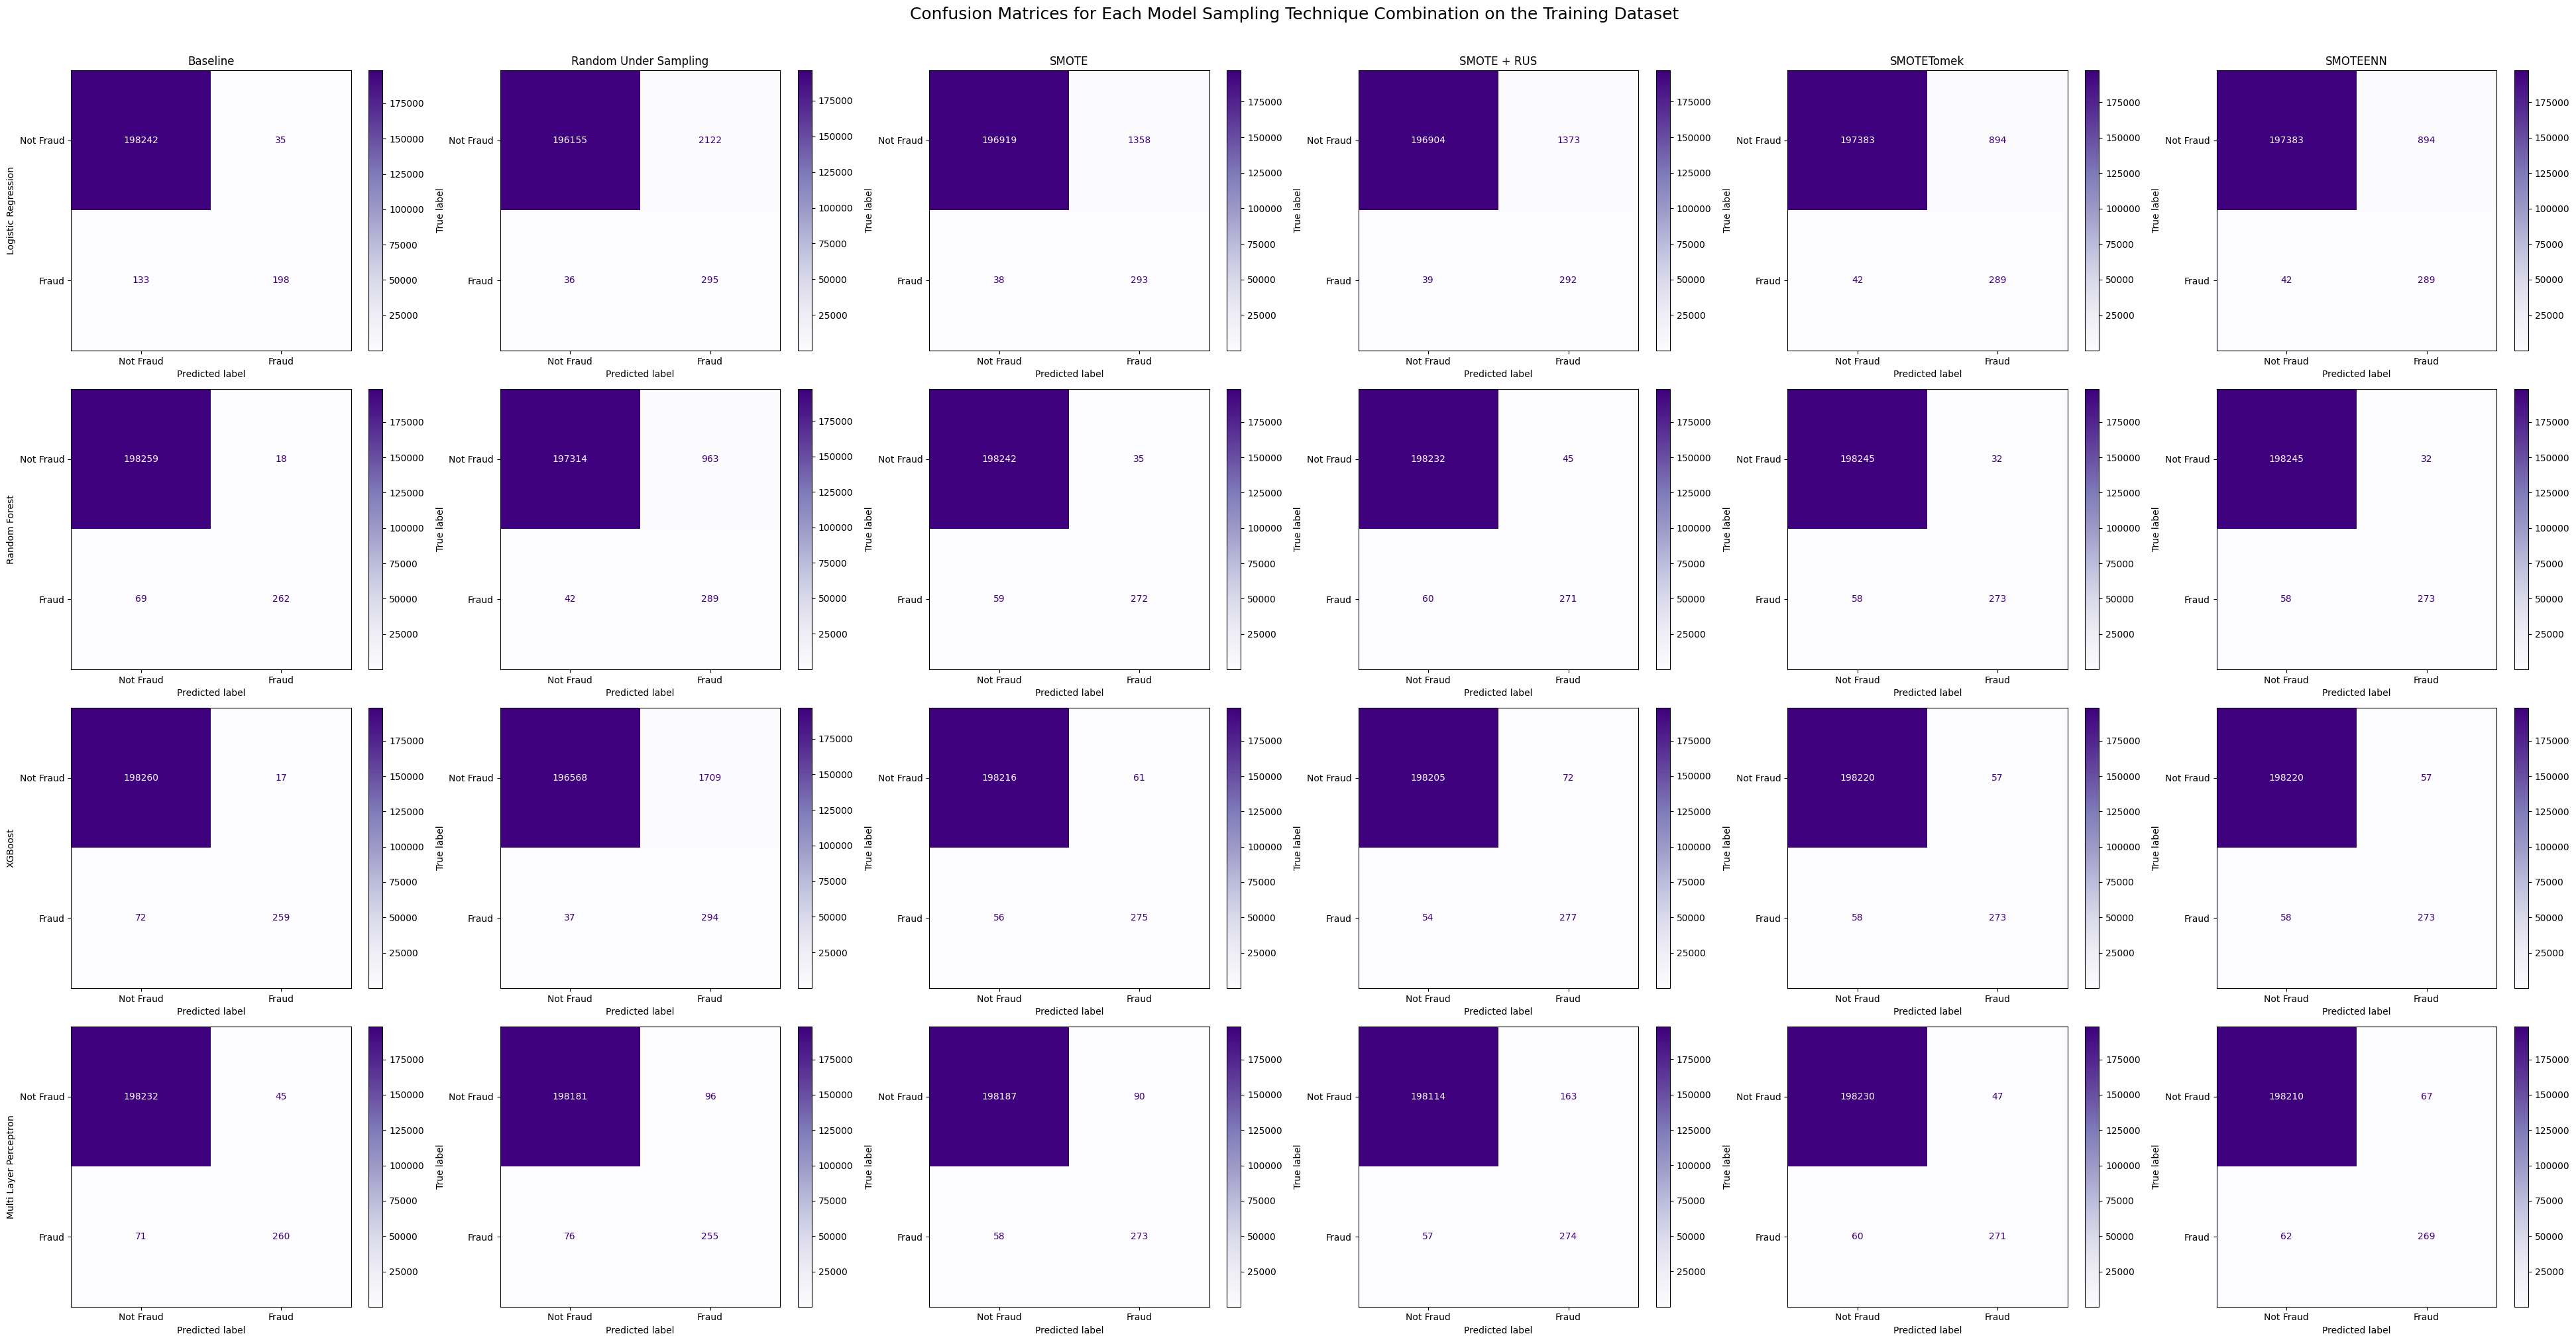

In [107]:
train_cms = plot_confusion_matrices(train_cms, model_names=['Logistic Regression','Random Forest','XGBoost','Multi Layer Perceptron'])
train_cms.savefig('../imgs/figs/train_cms.svg', bbox_inches='tight')

---
---
## Test Set Evaluations
While a test set should really be reserved for the final controlled test of a finished model, it is very useful at this stage to visualize the confusion matrices for each model to more closely investigate how these sampling techniques are impacting the learning process.

Visualizing the confusion matrix for a given model can help to better understand the number of True Positives (TPs), False Positives (FPs), True Negatives (TNs) and False Negatives (FNs). In this fraud detection scenario, we need a model that is primarily achieving the highest number of TPs (actual fraud cases) and the lowest number of FNs (misclassified fraud cases, or slipthroughs). As a secondary line of evaluation and important especially in the scaling and productivization of a model, there should be as few as possible FPs. Here is where fully understanding business and stakeholder needs is crucial to interpreting how to move forward with a given model. 

In [258]:
def evaluate_models(X_train, y_train, X_test, y_test, algorithms, pipelines=None, preprocessor='v1', scorers=None, normalize=None, cmap='Purples'):
    if not pipelines:
        raise ValueError('A dictionary of pipelines must be provided')
    if not algorithms or not isinstance(algorithms, dict):
        raise ValueError('A dictionary of models must be provided e.g. {"logistic Regression": lr()})')
    
    y_true = y_test

    if scorers is None:
        scorers = {'Recall': recall_score}

    cm_dict = {'Model': [],'Sampling': []}
    
    for metric in scorers.keys():
        cm_dict[metric] = []

    cm_dict.update({'True Negative': [],'False Positive': [],'False Negative': [],'True Positive': []})

    num_models = len(algorithms)
    num_pipelines = len(pipelines)

    figsize = (num_pipelines * 6.5, num_models * 5)
    fig, axes = plt.subplots(num_models, num_pipelines, figsize=figsize, squeeze=False)
    for row, (alg_name, alg) in enumerate(algorithms.items()):
        for col, (sampling_name, pipe_steps) in enumerate(pipelines.items()):
            ax = axes[row, col] if num_models > 1 and num_pipelines >1 else axes[max(row, col)]
            pipe_steps = pipe_steps.copy()
            if preprocessor =='v1':
                preproc = preprocessor_v1
            else:
                preproc = preprocessor
            if preproc:
                pipe_steps.insert(0, ('preprocessor', preproc))
            
            pipe_steps.append(('classifier', alg))
            pipe = imbPipe(steps=pipe_steps)
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_test)

            ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize=normalize, values_format='d',
                                                    display_labels=['Not Fraud', 'Fraud'], cmap=cmap, ax=ax)
            
            if row == 0:
                ax.set_title(sampling_name)
            if col == 0:
                ax.set_ylabel(alg_name)

            cm = confusion_matrix(y_true, y_pred).flatten()
            cm_dict['Model'].append(alg_name)
            cm_dict['Sampling'].append(sampling_name)
            cm_dict['True Negative'].append(cm[0])
            cm_dict['False Positive'].append(cm[1])
            cm_dict['False Negative'].append(cm[2])
            cm_dict['True Positive'].append(cm[3])

            for metric, scorer in scorers.items():
                cm_dict[metric].append(round(scorer(y_true, y_pred), 2))

    plt.suptitle('Confusion Matrices for Each Model and Sampling Technique Combination on Test Set', fontsize=18, y=1.01)

    plt.tight_layout()
    plt.show()

    cm_df = pd.DataFrame(cm_dict).set_index(['Model', 'Sampling'])

    return fig, cm_df

In [109]:
def evaluate_models(X_train, y_train, X_test, y_test, algorithms, pipelines=None, preprocessor='v1', scorers=None, normalize=None, cmap='Purples'):
    if not pipelines:
        raise ValueError('A dictionary of pipelines must be provided')
    if not algorithms or not isinstance(algorithms, dict):
        raise ValueError('A dictionary of models must be provided e.g. {"logistic Regression": lr()})')
    
    y_true = y_test

    if scorers is None:
        scorers = {'Recall': recall_score}

    cm_dict = {'Model': [],'Sampling': []}
    
    for metric in scorers.keys():
        cm_dict[metric] = []

    cm_dict.update({'True Negative': [],'False Positive': [],'False Negative': [],'True Positive': []})

    fitted_models = {alg_name: {} for alg_name in algorithms.keys()}

    num_models = len(algorithms)
    num_pipelines = len(pipelines)

    figsize = (num_pipelines * 6.5, num_models * 5)
    fig, axes = plt.subplots(num_models, num_pipelines, figsize=figsize, squeeze=False)
    for row, (alg_name, alg) in enumerate(algorithms.items()):
        for col, (sampling_name, pipe_steps) in enumerate(pipelines.items()):
            ax = axes[row, col] if num_models > 1 and num_pipelines >1 else axes[max(row, col)]
            pipe_steps = pipe_steps.copy()
            if preprocessor =='v1':
                preproc = preprocessor_v1
            else:
                preproc = preprocessor
            if preproc:
                pipe_steps.insert(0, ('preprocessor', preproc))
            
            pipe_steps.append(('classifier', alg))
            pipe = imbPipe(steps=pipe_steps)
            pipe.fit(X_train, y_train)
            fitted_models[alg_name][sampling_name] = pipe
            y_pred = pipe.predict(X_test)

            ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize=normalize, values_format='d',
                                                    display_labels=['Not Fraud', 'Fraud'], cmap=cmap, ax=ax)
            
            if row == 0:
                ax.set_title(sampling_name)
            if col == 0:
                ax.set_ylabel(alg_name)

            cm = confusion_matrix(y_true, y_pred).flatten()
            cm_dict['Model'].append(alg_name)
            cm_dict['Sampling'].append(sampling_name)
            cm_dict['True Negative'].append(cm[0])
            cm_dict['False Positive'].append(cm[1])
            cm_dict['False Negative'].append(cm[2])
            cm_dict['True Positive'].append(cm[3])

            for metric, scorer in scorers.items():
                cm_dict[metric].append(round(scorer(y_true, y_pred), 2))

    plt.suptitle('Confusion Matrices for Each Model and Sampling Technique Combination on the Test Dataset', fontsize=18, y=1.01)

    plt.tight_layout()
    plt.show()

    cm_df = pd.DataFrame(cm_dict).set_index(['Model', 'Sampling'])

    return fig, cm_df, fitted_models

In [ ]:
def plot_pr_curves(fitted_models, X_test, y_test, min_recall=0.8):
    num_models = len(fitted_models)
    fig, axes = plt.subplots(1, num_models, figsize=(num_models * 6.5), sharey=True)

    if num_models == 1:
        axes = [axes]

    threshold_results = []

    for ax, (model_name, sampling_dict) in zip(axes, fitted_models.items()):
        for sampling_method, fitted_pipe in sampling_dict.items():
            y_probs = fitted_pipe.predict_proba(X_test)[:,1]

            precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
            pr_auc = auc(recall, precision)

            best_threshold = None
            best_f1 = 0
            for i, threshold in enumerate(thresholds):
                if recall[i] >= min_recall:
                    y_pred = (y_probs > threshold).astype(int)
                    f1 = f1_score(y_test, y_pred)
                    if f1 > best_f1:
                        best_f1 = f1
                        best_threshold = threshold
            
            threshold_results.append({'Model': model_name, 'Sampling': sampling_method, 'Best Threshold': best_threshold, f'Best F1 Score': best_f1})

            ax.plot(recall, precision, label=f'{sampling_method} (AUC = {pr_auc:.2f}')

        ax.set_xlabel('Recall')
        ax.set_title(model_name)
        ax.legend()

    axes[0].set_ylabel('Precision')
    plt.suptitle('Precision-Recall Curves For All Models & Sampling Techniques')
    plt.tight_layout()
    plt.show()

    thresholds_df = pd.DataFrame(threshold_results)

    return fig, thresholds_df

Epoch 1/100
4966/4966 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 0.0041 - precision_at_recall_5: 0.9994 - val_loss: 0.0012 - val_precision_at_recall_5: 0.8615
Epoch 2/100
4966/4966 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - loss: 0.0010 - precision_at_recall_5: 0.7232 - val_loss: 8.3196e-04 - val_precision_at_recall_5: 0.8824
Epoch 3/100
4966/4966 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 0.0010 - precision_at_recall_5: 0.7654 - val_loss: 7.6913e-04 - val_precision_at_recall_5: 0.8750
Epoch 4/100
4966/4966 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 7.8035e-04 - precision_at_recall_5: 0.7551 - val_loss: 9.8077e-04 - val_precision_at_recall_5: 0.8732
Epoch 5/100
4966/4966 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step - loss: 7.8302e-04 - precision_at_recall_5: 0.8553 - val_loss: 8.5504e-04 - val_precision_at_recall_5: 0.8750
Epoch 6/100
4966/4966 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 5.8285e-04 - precision_at_recall_5: 0.8596 - val_loss: 9.7256e-04 - val_precision_at_recall_5: 0.8676
Epoch 7/100
4966/496

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


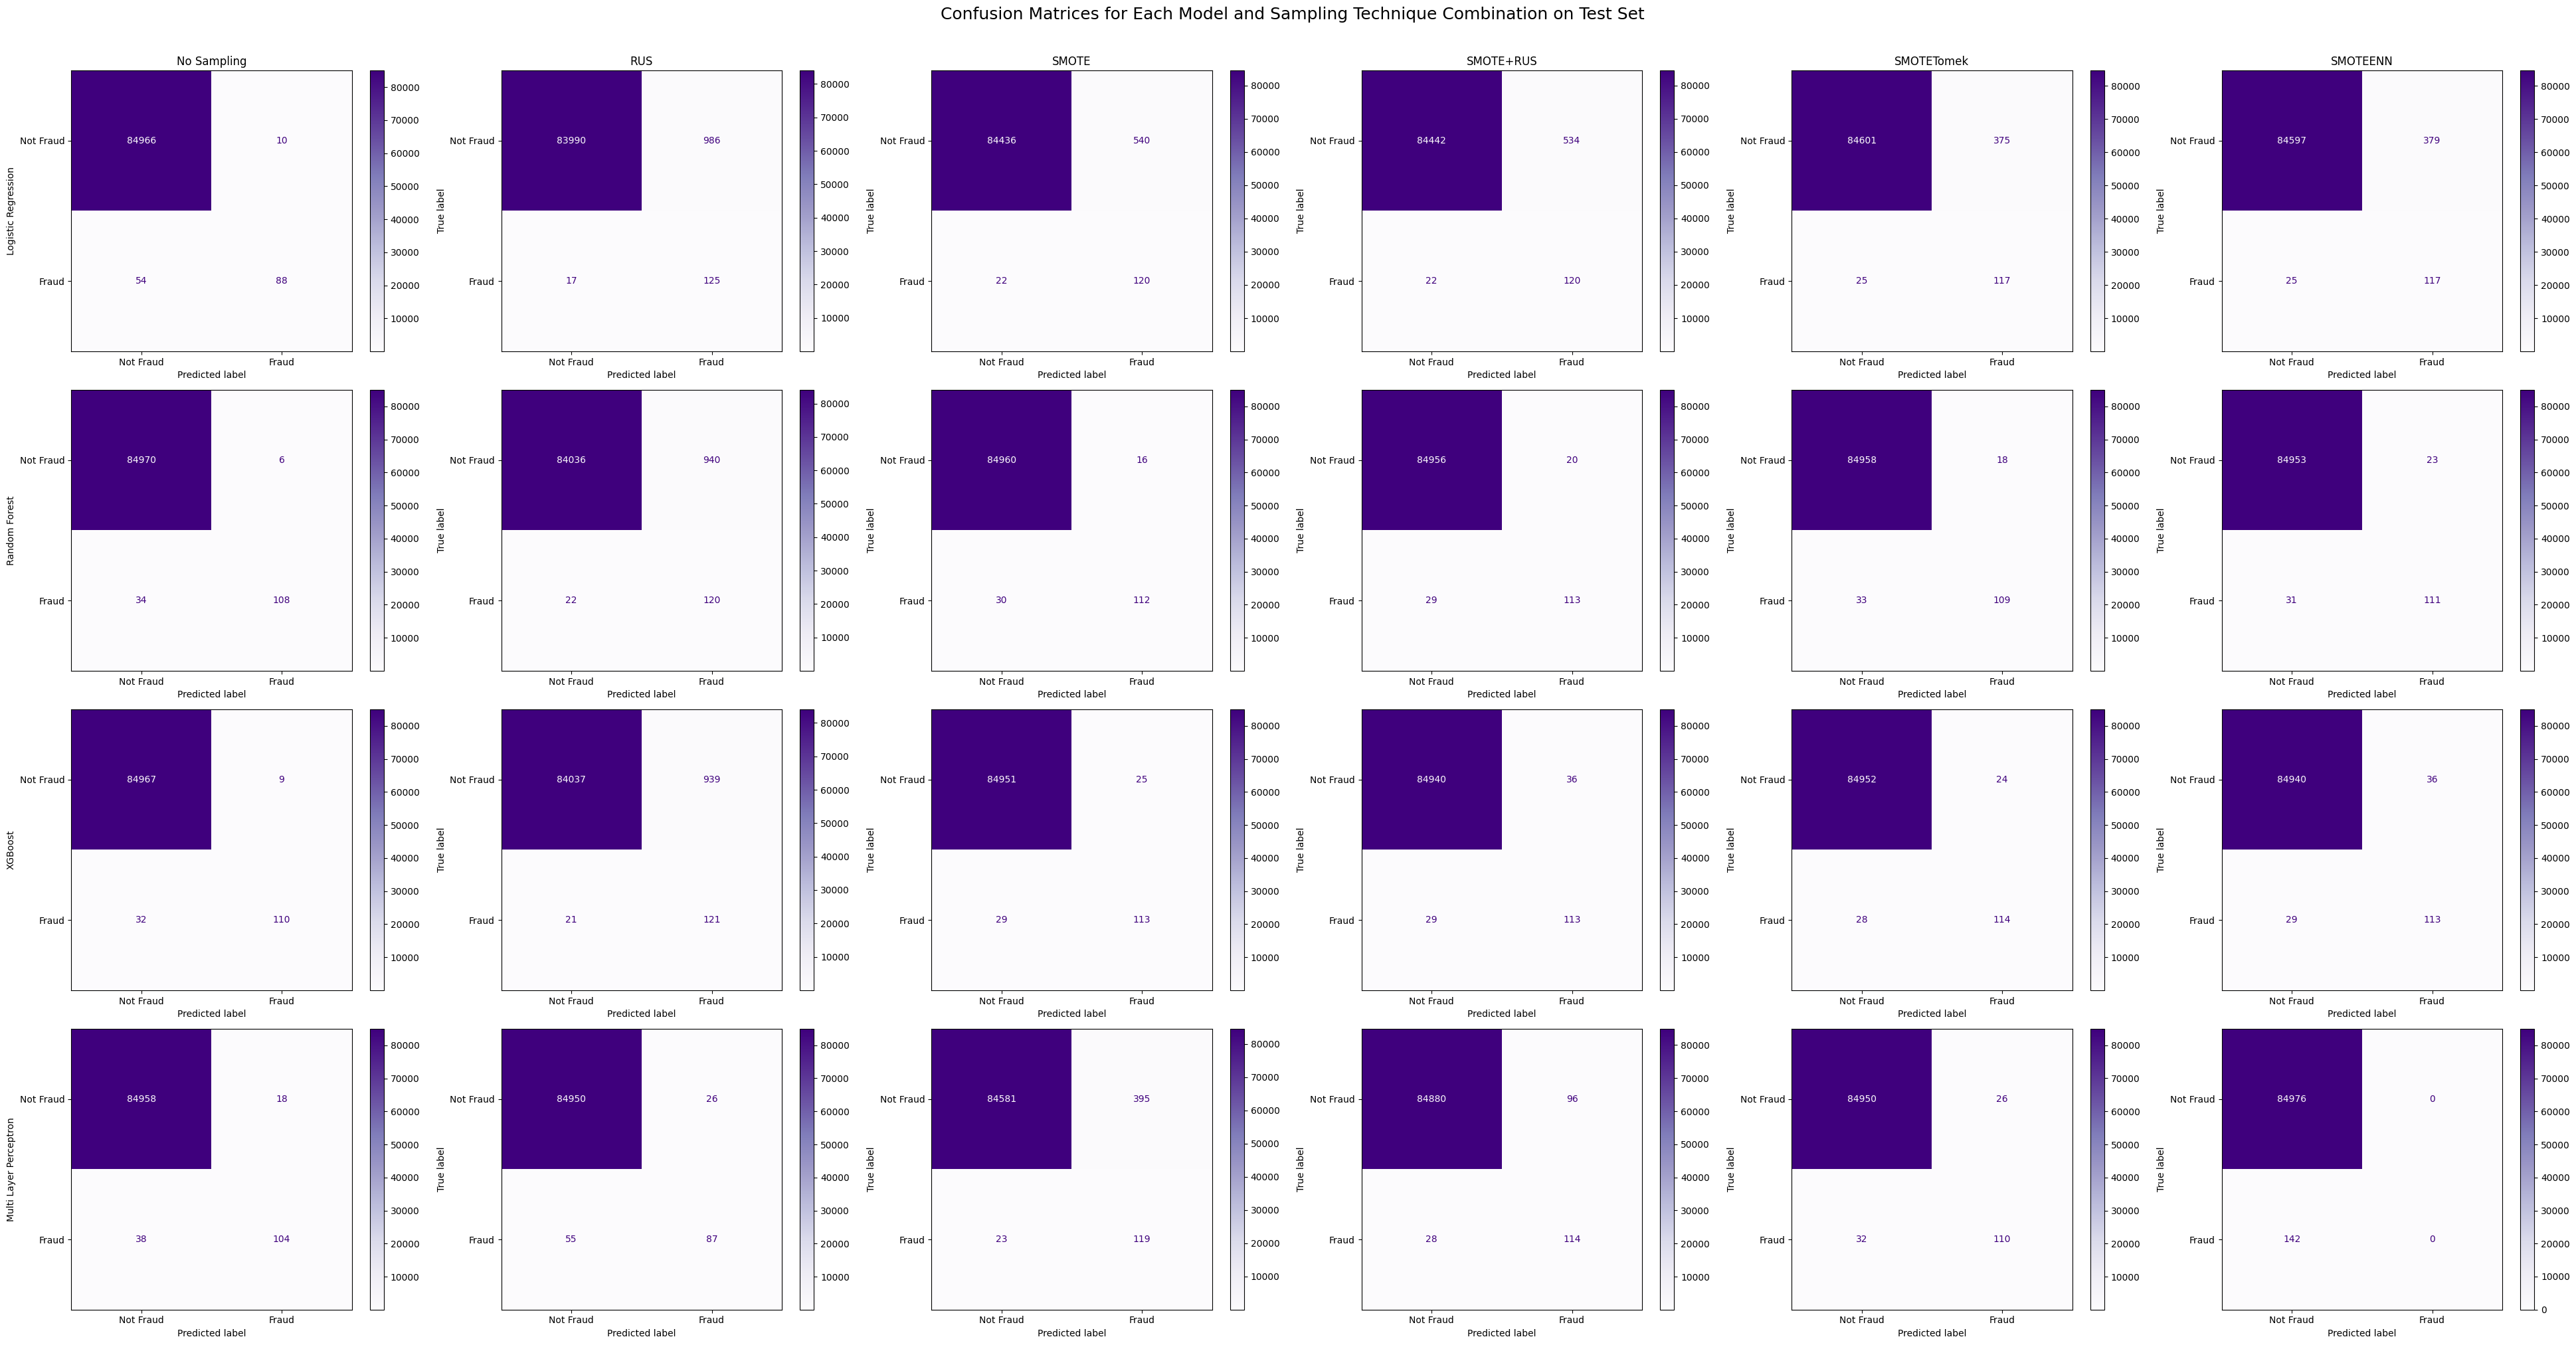

In [ ]:
# Redefine scorers to integrate with ...
scorers = {
    "Recall": recall_score,
    "Precision": precision_score,
    "F1 Score": f1_score,
    "PR-AUC": average_precision_score,
    "ROC-AUC": roc_auc_score
}

test_cms, test_scores_df, fitted_models_dict = evaluate_models(X_train, y_train, X_test, y_test, algorithms, pipelines=pipelines, scorers=scorers)

In [111]:
test_cms.savefig('../imgs/figs/test_cms.svg', bbox_inches='tight')
test_scores_df.to_csv('../data/test_scores.csv')

In [77]:
# test_scores_df = pd.read_csv('../data/test_scores.csv')
# test_scores_df = test_scores_df.set_index(['Model','Sampling'])

In [112]:
test_scores_df.sort_values(by='True Positive', ascending=False)

Recall  Precision  F1 Score  PR-AUC  \
Model                  Sampling                                           
Logistic Regression    RUS            0.88       0.11      0.20    0.10   
XGBoost                RUS            0.85       0.11      0.20    0.10   
Logistic Regression    SMOTE          0.85       0.18      0.30    0.15   
                       SMOTE+RUS      0.85       0.18      0.30    0.16   
Random Forest          RUS            0.85       0.11      0.20    0.10   
Multi Layer Perceptron SMOTE          0.84       0.23      0.36    0.19   
Logistic Regression    SMOTETomek     0.82       0.24      0.37    0.20   
                       SMOTEENN       0.82       0.24      0.37    0.19   
Multi Layer Perceptron SMOTE+RUS      0.80       0.54      0.65    0.44   
XGBoost                SMOTETomek     0.80       0.83      0.81    0.66   
Random Forest          SMOTE+RUS      0.80       0.85      0.82    0.68   
XGBoost                SMOTEENN       0.80       0.76      0.78    0.60   
                       SMOTE          0.80       0.82      0.81    0.65   
                       SMOTE+RUS      0.80       0.76      0.78    0.60   
Random Forest          SMOTE          0.79       0.88      0.83    0.69   
                       SMOTEENN       0.78       0.83      0.80    0.65   
Multi Layer Perceptron SMOTETomek     0.77       0.81      0.79    0.63   
XGBoost                No Sampling    0.77       0.92      0.84    0.72   
Random Forest          SMOTETomek     0.77       0.86      0.81    0.66   
                       No Sampling    0.76       0.95      0.84    0.72   
Multi Layer Perceptron No Sampling    0.73       0.85      0.79    0.62   
Logistic Regression    No Sampling    0.62       0.90      0.73    0.56   
Multi Layer Perceptron RUS            0.61       0.77      0.68    0.47   
                       SMOTEENN       0.00       0.00      0.00    0.00   

                                    ROC-AUC  True Negative  False Positive  \
Model                  Sampling                                              
Logistic Regression    RUS             0.93          83990             986   
XGBoost                RUS             0.92          84037             939   
Logistic Regression    SMOTE           0.92          84436             540   
                       SMOTE+RUS       0.92          84442             534   
Random Forest          RUS             0.92          84036             940   
Multi Layer Perceptron SMOTE           0.92          84581             395   
Logistic Regression    SMOTETomek      0.91          84601             375   
                       SMOTEENN        0.91          84597             379   
Multi Layer Perceptron SMOTE+RUS       0.90          84880              96   
XGBoost                SMOTETomek      0.90          84952              24   
Random Forest          SMOTE+RUS       0.90          84956              20   
XGBoost                SMOTEENN        0.90          84940              36   
                       SMOTE           0.90          84951              25   
                       SMOTE+RUS       0.90          84940              36   
Random Forest          SMOTE           0.89          84960              16   
                       SMOTEENN        0.89          84953              23   
Multi Layer Perceptron SMOTETomek      0.89          84950              26   
XGBoost                No Sampling     0.89          84967               9   
Random Forest          SMOTETomek      0.88          84958              18   
                       No Sampling     0.88          84970               6   
Multi Layer Perceptron No Sampling     0.87          84958              18   
Logistic Regression    No Sampling     0.81          84966              10   
Multi Layer Perceptron RUS             0.81          84950              26   
                       SMOTEENN        0.50          84976               0   

                                    False Negative  True

---
---
## Selecting Models for Hyperparameter Tuning

Since my final goal of this project is to investigate threshold tuning, i first need to decide which models are the best candidates for hyperparameter and threshold tuning. Hyperparameter tuning needs to be performed first as it will alter model weights and therefore potentially stabilize model weights. 

I am going to consider models for tuning based on them having high recall (>= 0.76) and precision (>= 0.8). This will show that the model has room for improvement in recall-precision balance. That is, that some precision can be sacrificed to achieve higher recall.

In [117]:
test_scores_df.query('Recall >= 0.76 & Precision >= 0.8').sort_values(by='F1 Score', ascending=False)

Recall  Precision  F1 Score  PR-AUC  \
Model                  Sampling                                           
Random Forest          No Sampling    0.76       0.95      0.84    0.72   
XGBoost                No Sampling    0.77       0.92      0.84    0.72   
Random Forest          SMOTE          0.79       0.88      0.83    0.69   
                       SMOTE+RUS      0.80       0.85      0.82    0.68   
                       SMOTETomek     0.77       0.86      0.81    0.66   
XGBoost                SMOTE          0.80       0.82      0.81    0.65   
                       SMOTETomek     0.80       0.83      0.81    0.66   
Random Forest          SMOTEENN       0.78       0.83      0.80    0.65   
Multi Layer Perceptron SMOTETomek     0.77       0.81      0.79    0.63   

                                    ROC-AUC  True Negative  False Positive  \
Model                  Sampling                                              
Random Forest          No Sampling     0.88          84970               6   
XGBoost                No Sampling     0.89          84967               9   
Random Forest          SMOTE           0.89          84960              16   
                       SMOTE+RUS       0.90          84956              20   
                       SMOTETomek      0.88          84958              18   
XGBoost                SMOTE           0.90          84951              25   
                       SMOTETomek      0.90          84952              24   
Random Forest          SMOTEENN        0.89          84953              23   
Multi Layer Perceptron SMOTETomek      0.89          84950              26   

                                    False Negative  True Positive  
Model                  Sampling                                    
Random Forest          No Sampling              34            108  
XGBoost                No Sampling              32            110  
Random Forest          SMOTE                    30            112  
                       SMOTE+RUS                29            113  
                       SMOTETomek               33            109  
XGBoost                SMOTE                    29            113  
                       SMOTETomek               28            114  
Random Forest          SMOTEENN                 31            111  
Multi Layer Perceptron SMOTETomek               32            110

1. Random Forest and XGBoost with no sampling applied are good candidates for simply moving on to threshold tuning, however i am goign to try a simple GridSearch to improve performance. I am particularly interested in the impact of the parameter/arg set up, `class_weight`='balanced.
2. I will then do a more extensive RandomizedSearchCV of Random Forest with SMOTE, Random Forest with SMOTE and RUS, XGBoost with SMOTE

---
---
## Hyperparameter Tuning with RandomizedSearchCV

In [120]:
def random_search_cv(algorithm, pipe_steps, param_grid, preprocessor='v1', scoring=None, n_iter=10, verbose=1, n_jobs=-1):
    
    if preprocessor == 'v1':
        preproc = ColumnTransformer(
            transformers=[('drop_cols', 'drop', ['Time', 'Amount'])],
            remainder='passthrough')
    else:
        preproc = preprocessor

    steps = pipe_steps.copy()

    if preproc:
        steps.insert(0, ('preprocessor', preproc))

    steps.append(('classifier', algorithm))

    pipe = imbPipe(steps=steps)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

    rscv = RandomizedSearchCV(pipe,
                              param_distributions=param_grid,
                              n_iter=n_iter,
                              cv=skf,
                              scoring=scoring,
                              random_state=13,
                              return_train_score=True,
                              n_jobs=n_jobs)
    
    rscv.fit(X_train, y_train)

    all_results_df = pd.DataFrame(rscv.cv_results_)
    best_params = rscv.best_params_
    best_score = rscv.best_score_
    best_model = rscv.best_estimator_

    return best_model, best_params, best_score, all_results_df

In [128]:
rf_param_grid = {
    'classifier__n_estimators': [100, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 5, 10],
    'classifier__class_weight': [None, 'balanced']
}

xgb_param_grid = {
    'classifier__n_estimators': [100, 300],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.7, 0.9],
    'classifier__colsample_bytree': [0.7, 0.9],
    'classifier__scale_pos_weight': [1, sum(y_train == 0) / sum(y_train == 1)]
}

In [134]:
scorers = {
    "Recall": make_scorer(recall_score, average="binary"),
    "Precision": make_scorer(precision_score, average="binary"),
    "F1 Score": make_scorer(f1_score, average="binary"),
    # "PR-AUC": make_scorer(average_precision_score, response_method='predict'),
    # "ROC-AUC": make_scorer(roc_auc_score, response_method='predict')
}

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor_v1),
    ('classifier', rf)
])

rf_ns_gs = GridSearchCV(rf_pipe, rf_param_grid, scoring=scorers, refit='Recall', return_train_score=True, cv=skf, n_jobs=-1, verbose=3)
rf_ns_gs.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END classifier__class_weight=None, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; F1 Score: (train=0.998, test=0.786) Precision: (train=1.000, test=0.957) Recall: (train=0.996, test=0.667) total time= 4.6min
[CV 3/5] END classifier__class_weight=None, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; F1 Score: (train=1.000, test=0.887) Precision: (train=1.000, test=0.965) Recall: (train=1.000, test=0.821) total time= 5.0min
[CV 2/5] END classifier__class_weight=None, classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; F1 Score: (train=1.000, test=0.899) Precision: (train=1.000, test=0.921) Recall: (train=1.000, test=0.879) total time= 5.0min
[CV 4/5] END classifier__class_weight=None, classifier__ma

In [ ]:
xgb_ns_gs = GridSearchCV(fitted_models_dict['XGBoost']['No Sampling'], xgb_param_grid, scoring=scorers, refit='Recall', return_train_score=True, cv=skf, n_jobs=-1, verbose=2)
xgb_ns_gs.fit(X_train, y_train)

In [28]:
grids = {
    'logreg_rus': {
        'rus__sampling_strategy': uniform(loc=0.2, scale=0.6),  # Reduce extreme values
        'classifier__max_iter': randint(500, 2000),  # Avoid unnecessary high values
        'classifier__C': loguniform(0.01, 5.0)  # More practical range
    },

    'xgboost_smote': {
        'smote__sampling_strategy': uniform(loc=0.2, scale=0.6),  # Reduce extreme resampling
        'smote__k_neighbors': randint(3, 6),  # Limit range for efficiency
        'classifier__n_estimators': randint(100, 300),  # Smaller range
        'classifier__max_depth': randint(3, 8),  # Prevent excessive depth
        'classifier__learning_rate': loguniform(0.01, 0.2),  # More stable range
        'classifier__subsample': uniform(loc=0.7, scale=0.3)  # Avoid very low values
    },

    'rf_smote_rus': {
        'smote__sampling_strategy': uniform(loc=0.2, scale=0.6),
        'smote__k_neighbors': randint(3, 6),
        'rus__sampling_strategy': uniform(loc=0.2, scale=0.6),
        'classifier__n_estimators': randint(100, 300),  # Avoid huge trees
        'classifier__max_depth': randint(5, 15),  # More controlled depth
        'classifier__min_samples_split': randint(2, 10),  # Reasonable limits
        'classifier__min_samples_leaf': randint(1, 5)  # Prevent overfitting
    },

    'mlp_': {
        'mlp__model__learning_rate': uniform(0.0005, 0.003),  # Tighter range
        'mlp__model__neurons': randint(64, 128),
        'mlp__model__dropout_rate': uniform(0.2, 0.4),
        'mlp__epochs': [50, 100],  # Keep epochs manageable
        'mlp__batch_size': [32, 64]
    }
}

In [ ]:
lr_best_model, lr_best_params, lr_best_score, lr_cv_results = random_search_cv(algorithms['Logistic Regression'], pipe_steps=pipelines['RUS'], param_grid=grids['logreg_rus'], scoring='average_precision')

In [ ]:
lr_randsearch = lr_best_model
dump(lr_randsearch, '../models/lr_rus.joblib')

In [30]:
xgb_best_model, xgb_best_params, xgb_best_score, xgb_cv_results = random_search_cv(algorithms['XGBoost'], pipe_steps=pipelines['SMOTE'], param_grid=grids['xgboost_smote'], scoring='average_precision')

In [ ]:
xgb_randsearch = xgb_best_model
dump(lr_randsearch, '../models/xgb_smote.joblib')

In [ ]:
rf_best_model, rf_best_params, rf_best_score, rf_cv_results = random_search_cv(algorithms['Random Forest'], pipe_steps=pipelines['SMOTE+RUS'], param_grid=grids['rf_smote_rus'], scoring='average_precision')

In [ ]:
rf_randsearch = rf_best_model
dump(lr_randsearch, '../models/rf_smote_rus.joblib')

In [ ]:
mlp_best_model, mlp_best_params, mlp_best_score, mlp_cv_results = random_search_cv(algorithms['Multi Layer Perceptron'], pipe_steps=pipelines['SMOTE+RUS'], param_grid=grids['mlp_'], scoring='average_precision')

In [48]:
best_models = {
    'Logistic Regression: RUS': lr_best_model,
    'Random Forest: SMOTE + RUS': rf_best_model,
    'XGBoost: SMOTE': xgb_best_model,
    'MLP:': mlp_best_model
}